In [ ]:
from importlib import reload

import numpy as np
from matplotlib import pyplot as plt
import jax
from jax import numpy as jnp
jax.config.update("jax_enable_x64", True)

import nudging
import simultaneous

reload(nudging)
reload(simultaneous)

jndarray = jnp.ndarray

simulate_simultaneous = nudging.simulate_simultaneous
plot_error = nudging.plot_error

In [ ]:
def get_initial_values(system):
    SEED = 42

    I, J, J_sim = system.I, system.J, system.J_sim

    # Initial true state
    init = np.random.default_rng(SEED).uniform(size=I + I * J)

    u0 = jnp.array(init[:I])
    v0 = jnp.array(jnp.reshape(init[I:], (I, J)))

    # Initial simulation state
    u0_sim = jnp.zeros_like(u0)
    v0_sim = jnp.zeros((I, J_sim))

    return u0, v0, u0_sim, v0_sim


def simulate(system, solver, t0, tf, dt, u0, v0, u0_sim, v0_sim):
    U, V, Un, Vn = solver.solve(
        system,
        u0,
        v0,
        u0_sim,
        v0_sim,
        t0,
        tf,
        dt,
    )

    tls = jnp.arange(t0, tf, dt)
    true_tf = tls[-1]

    return U, V, Un, Vn, true_tf

In [ ]:
# Dimensions
I, J = 40, 5
J_sim = J

# System evolution parameters
γ1, γ2 = 1e-2, 0.5
c1, c2 = γ1, γ2
c1 *= 1.1
# c2 *= 1.1
ds = jnp.array([0.2, 0.5, 1, 2, 5])
F = 8
μ = 50

dt = 0.025
r = 1e-4

T0, Tf = 0, 2000
t_relax = 200

In [ ]:
system = simultaneous.System(I, J, J_sim, γ1, γ2, c1, c2, ds, F, μ)
solver = simultaneous.RK4(system)

t0 = T0
tf = t0 + t_relax
u0, v0, u0_sim, v0_sim = get_initial_values(system)

c1s = [system.c1]
c2s = [system.c2]

u_errors = []
v_errors = []

while tf <= Tf:
    U, V, Un, Vn = solver.solve(system, u0, v0, u0_sim, v0_sim, t0, tf, dt)
    
    u0, v0, u0_sim, v0_sim = U[-1], V[-1], Un[-1], Vn[-1]
    t0 = tf
    tf = t0 + t_relax

    # Update parameters
    c1, c2 = simultaneous.gradient_descent(system, u0, u0_sim, v0_sim, r)
    system.c1 = c1
    system.c2 = c2
    c1s.append(c1)
    c2s.append(c2)

    u_errors.append(np.linalg.norm(U - Un, axis=1))
    v_errors.append(np.linalg.norm(V - Vn, axis=(1, 2)))

u_errors = np.concatenate(u_errors)
v_errors = np.concatenate(v_errors)

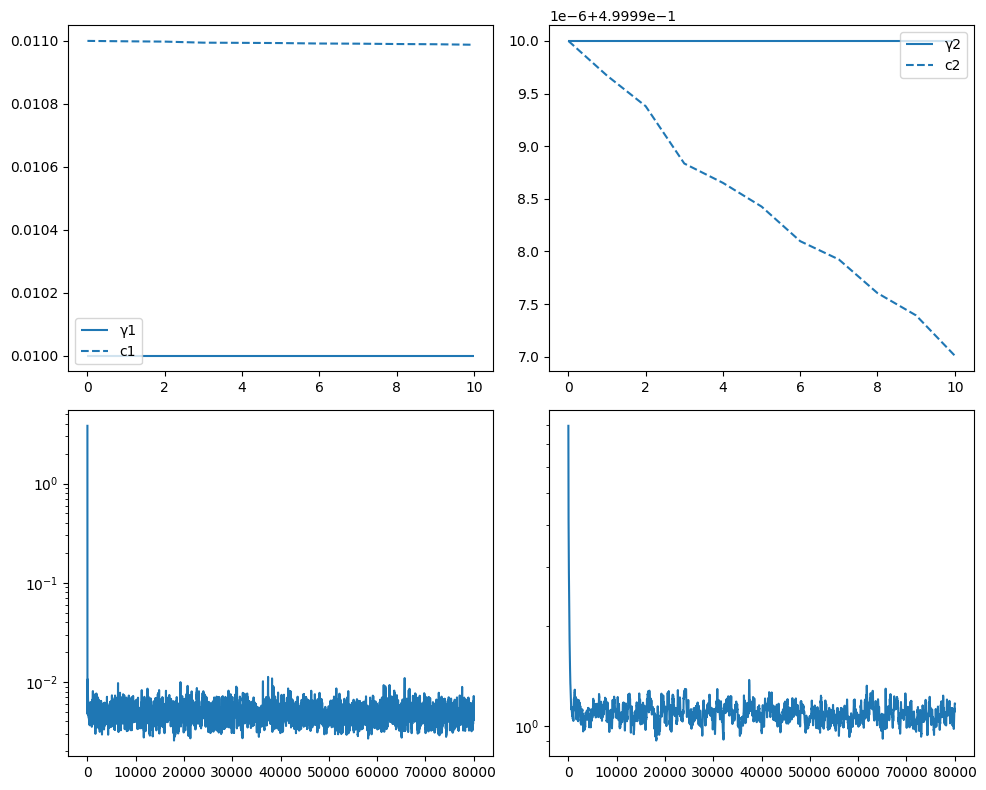

In [ ]:
iters = len(c1s)
ils = np.arange(iters)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

ax = axs[0, 0]
ax.hlines(γ1, ils[0], ils[-1], label="γ1")
ax.plot(ils, c1s, linestyle="--", label="c1")
ax.legend()

ax = axs[0, 1]
ax.hlines(γ2, ils[0], ils[-1], label="γ2")
ax.plot(ils, c2s, linestyle="--", label="c2")
ax.legend()

ax = axs[1, 0]
ax.plot(u_errors)
ax.set_yscale("log")

ax = axs[1, 1]
ax.plot(v_errors)
ax.set_yscale("log")

fig.tight_layout()
plt.show()